The dataset is 1,000,000 rows but a sample size of 10000 is used to save time. However, it is stratified to maintain the same fraud ratio.

In [16]:
import pandas as pd

df = pd.read_csv("../data/card_transdata.csv")
df.drop_duplicates(inplace=True)

# perform stratified sampling
fraud_ratio = df["fraud"].value_counts(normalize=True)
df_sample = df.groupby("fraud", group_keys=False).apply(lambda x: x.sample(frac=10000 / len(df), random_state=42))

# verify the fraud ratio in the sample
original_fraud_ratio = df["fraud"].mean()
sample_fraud_ratio = df_sample["fraud"].mean()

# display the sampled df and verify fraud ratios
print(df_sample.head())
print(fraud_ratio.to_dict())
print(f"Original Fraud Ratio: {original_fraud_ratio:.4f}")
print(f"Sample Fraud Ratio: {sample_fraud_ratio:.4f}")
df = df_sample

        distance_from_home  distance_from_last_transaction  \
763547            8.073065                        0.614990   
23634            31.994433                        5.808574   
157152            8.015637                        4.319242   
238071            6.230256                        0.796154   
846711           44.997072                       10.943190   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
763547                        0.077806              1.0        0.0   
23634                         1.186485              1.0        0.0   
157152                        0.906554              1.0        0.0   
238071                        0.206875              1.0        1.0   
846711                        0.856966              1.0        0.0   

        used_pin_number  online_order  fraud  
763547              0.0           1.0    0.0  
23634               1.0           0.0    0.0  
157152              0.0           1.0    0.0  
238071            

C:\Users\wyman\AppData\Local\Temp\ipykernel_35092\398348881.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby("fraud", group_keys=False).apply(lambda x: x.sample(frac=10000 / len(df), random_state=42))


This block inspects the dataset for missing values and general information, such as data types and statistical summaries.

In [17]:
# check for missing values
print("Missing values:\n", df.isnull().sum())

# visualize basic statistics
print("Dataset Info:\n")
df.info()
print("\nSummary Statistics:\n")
print(df.describe())

Missing values:
 distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 763547 to 128321
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              10000 non-null  float64
 1   distance_from_last_transaction  10000 non-null  float64
 2   ratio_to_median_purchase_price  10000 non-null  float64
 3   repeat_retailer                 10000 non-null  float64
 4   used_chip                       10000 non-null  float64
 5   used_pin_number                 10000 non-null  float64
 6   online_order                    10000 non-null  float64
 7   frau

This block normalizes the numeric features using StandardScaler to ensure that the GMM algorithm performs effectively. StandardScaler normalizes the data such that the Mean equals 0 and the Standard Deviation equals 1. The binary columns are left unchanged.

In [18]:
from sklearn.preprocessing import StandardScaler

# separate features and labels
X = df.drop(columns=['fraud'], axis=1) 
y = df['fraud'] 

# separate binary columns
binary_columns = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]

# separate continuous columns
continuous_columns = [col for col in X.columns if col not in binary_columns]

# scale only the continuous columns
scaler = StandardScaler()
X_scaled_continuous = scaler.fit_transform(df[continuous_columns])

# combine binary and scaled continuous data
X_scaled = pd.concat(
    [pd.DataFrame(X_scaled_continuous, columns=continuous_columns), X[binary_columns].reset_index(drop=True)],
    axis=1
)

# check that the classification labels were split properly
print("\nValue Counts for Target Labels:")
print(y.value_counts())
print(f"Fraud ratio: {y.mean()}")

# check that the other features were properly scaled
X_scaled.head()


Value Counts for Target Labels:
fraud
0.0    9126
1.0     874
Name: count, dtype: int64
Fraud ratio: 0.0874


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,-0.300468,-0.171813,-0.620199,1.0,0.0,0.0,1.0
1,0.069724,0.029595,-0.233014,1.0,0.0,1.0,0.0
2,-0.301357,-0.028162,-0.330774,1.0,0.0,0.0,1.0
3,-0.328986,-0.164787,-0.575124,1.0,1.0,0.0,0.0
4,0.270945,0.228716,-0.348092,1.0,0.0,0.0,1.0


PCA is run with various combinations of retained variance thresholds and cluster amount combinations to determine the optimal set of parameters based primarily on the silhouette score which is a value that measures how well connected the clusters are. The best combination of parameters is maintained for later testing. As expected, 2 clusters are usually optimal because the problem is trying to classify between two classes, fraud and non-fraud.

PCA Threshold: 0.7, Clusters: 2, Silhouette Score: 0.9756, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, Clusters: 3, Silhouette Score: 0.8567, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.7, Clusters: 4, Silhouette Score: 0.7933, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.8, Clusters: 2, Silhouette Score: 0.9756, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.8, Clusters: 3, Silhouette Score: 0.8567, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.8, Clusters: 4, Silhouette Score: 0.7933, Retained Components: 3, Removed Components: 4
PCA Threshold: 0.9, Clusters: 2, Silhouette Score: 0.2366, Retained Components: 5, Removed Components: 2
PCA Threshold: 0.9, Clusters: 3, Silhouette Score: 0.2445, Retained Components: 5, Removed Components: 2
PCA Threshold: 0.9, Clusters: 4, Silhouette Score: 0.2632, Retained Components: 5, Removed Components: 2
PCA Threshold: 0.95, Clusters: 2, Silhouette Score: 0.2

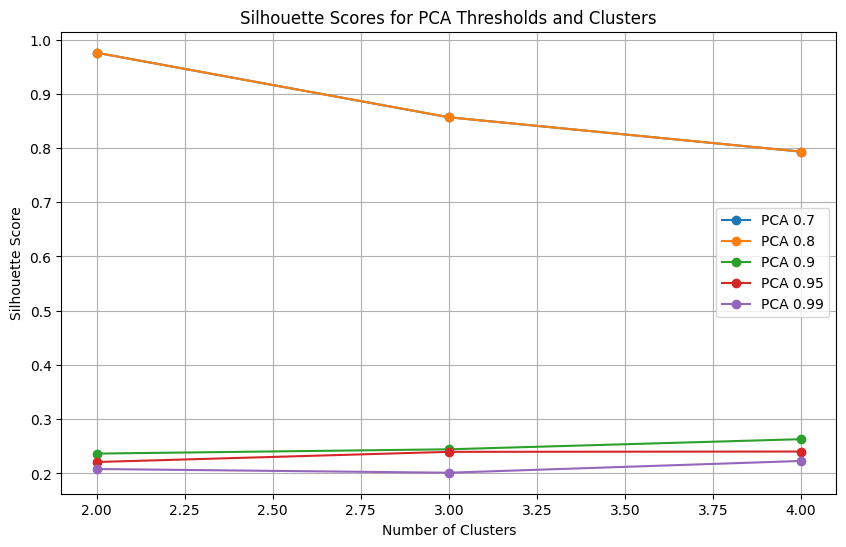

In [ ]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# define PCA thresholds and cluster range
pca_thresholds = [0.70, 0.80, 0.90, 0.95, 0.99]
cluster_range = range(2, 5)

# store (pca_threshold, n_clusters, silhouette_score)
pca_results = []  

original_components = X_scaled.shape[1]

for pca_threshold in pca_thresholds:
    # apply PCA with the current threshold
    pca = PCA(n_components=pca_threshold)
    X_pca = pca.fit_transform(X_scaled)

    # count retained and removed components
    retained_components = pca.n_components_
    removed_components = original_components - retained_components

    # iterate over the range of clusters
    for n_clusters in cluster_range:
        # train Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_clusters, n_init=50, covariance_type='tied', random_state=42)
        labels = gmm.fit_predict(X_pca)

        # calculate the silhouette score
        silhouette_avg = silhouette_score(X_pca, labels)
        pca_results.append((pca_threshold, n_clusters, silhouette_avg))
        # print details
        print(
            f"PCA Threshold: {pca_threshold}, Clusters: {n_clusters}, "
            f"Silhouette Score: {silhouette_avg:.4f}, "
            f"Retained Components: {retained_components}, Removed Components: {removed_components}"
        )

# find the best combination of PCA threshold and number of clusters
best_pca_threshold, best_pca_clusters, best_pca_silhouette = max(pca_results, key=lambda x: x[2])
print(f"\nBest PCA Threshold: {best_pca_threshold}, Best PCA Clusters: {best_pca_clusters}, Best PCA Silhouette Score: {best_pca_silhouette:.4f}")

# visualize silhouette cores
results_array = np.array(pca_results)
plt.figure(figsize=(10, 6))
for threshold in pca_thresholds:
    scores = results_array[results_array[:, 0] == threshold][:, 2].astype(float)
    plt.plot(cluster_range, scores, marker='o', label=f'PCA {threshold}')

plt.title("Silhouette Scores for PCA Thresholds and Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid()
plt.show()

t-SNE is run with a various range of perplexities of and cluster amount combinations to determine the optimal set of parameters  based primarily on the silhouette score and the ARI. The trustworthiness is useful to verify that the local structure of the data is properly reflected after the dimension reduction, but the other metrics better measure how well the data is preservered after being reduced. t-SNE doesn't always prefer 2 clusters. I think this is because this method always reduces the data to 2 dimensions (compared to PCA which is variable) which can substantially alter the way the data is preserved, causing the model to recognize more clusters.

t-SNE Perplexity: 5, Clusters: 2, Silhouette Score: 0.3321, ARI: 0.0030, Trustworthiness: 0.9997
t-SNE Perplexity: 5, Clusters: 3, Silhouette Score: 0.3611, ARI: 0.0043, Trustworthiness: 0.9997
t-SNE Perplexity: 5, Clusters: 4, Silhouette Score: 0.3547, ARI: 0.0057, Trustworthiness: 0.9997
t-SNE Perplexity: 10, Clusters: 2, Silhouette Score: 0.3444, ARI: -0.0006, Trustworthiness: 0.9997
t-SNE Perplexity: 10, Clusters: 3, Silhouette Score: 0.2453, ARI: 0.0219, Trustworthiness: 0.9997
t-SNE Perplexity: 10, Clusters: 4, Silhouette Score: 0.3002, ARI: 0.0152, Trustworthiness: 0.9997
t-SNE Perplexity: 20, Clusters: 2, Silhouette Score: 0.3579, ARI: 0.0008, Trustworthiness: 0.9997
t-SNE Perplexity: 20, Clusters: 3, Silhouette Score: 0.3839, ARI: 0.0215, Trustworthiness: 0.9997
t-SNE Perplexity: 20, Clusters: 4, Silhouette Score: 0.3847, ARI: 0.0105, Trustworthiness: 0.9997
t-SNE Perplexity: 30, Clusters: 2, Silhouette Score: 0.3760, ARI: -0.0021, Trustworthiness: 0.9996
t-SNE Perplexity: 30,

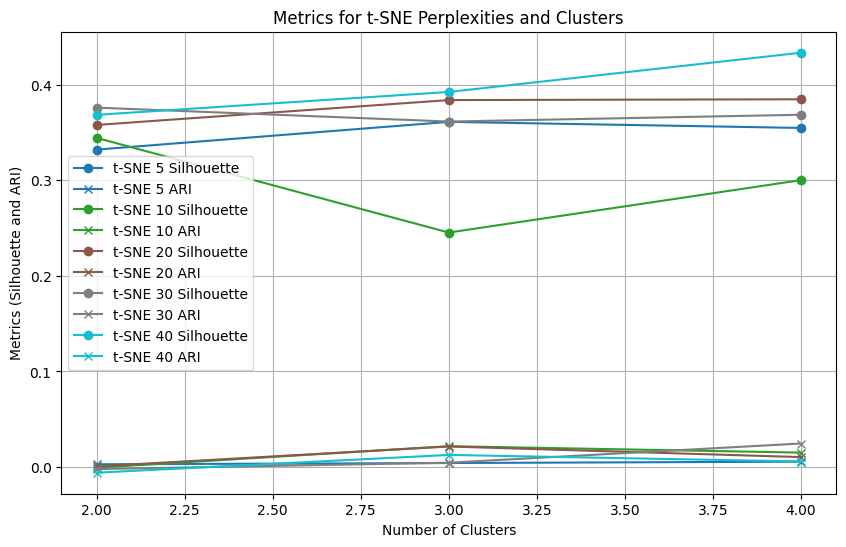

In [ ]:
from sklearn.manifold import TSNE, trustworthiness
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# define t-SNE perplexity values and cluster range
tsne_perplexities = [5, 10, 20, 30, 40]
cluster_range = range(2, 5)

# so store (perplexity, n_clusters, silhouette_score, ARI, trustworthiness)
tsne_results = []  

# iterate over t-SNE perplexities
for perplexity in tsne_perplexities:

    # apply t-SNE with the current perplexity
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate=200)
    X_tsne = tsne.fit_transform(X_scaled)

    # calculate trustworthiness for this t-SNE trial
    trust = trustworthiness(X_scaled, X_tsne, n_neighbors=5)

    # iterate over the range of clusters
    for n_clusters in cluster_range:
        # train gmm
        gmm = GaussianMixture(n_components=n_clusters, n_init=50, covariance_type='tied', random_state=42)
        labels = gmm.fit_predict(X_tsne)

        # calculate silhouette score and ARI
        silhouette_avg = silhouette_score(X_tsne, labels)
        ari_score = adjusted_rand_score(y, labels)

        # store results
        tsne_results.append((perplexity, n_clusters, silhouette_avg, ari_score, trust))

        # print details
        print(
            f"t-SNE Perplexity: {perplexity}, Clusters: {n_clusters}, "
            f"Silhouette Score: {silhouette_avg:.4f}, ARI: {ari_score:.4f}, "
            f"Trustworthiness: {trust:.4f}"
        )

# find the optimal parameters based on ARI and silhouette score, preferring closer to 2 clusters
best_tsne_trial = max(
    tsne_results,
    key=lambda x: (x[3], x[2], -(x[1] == 2))  # prioritize ARI, then silhouette, with slight preference for 2 clusters
)
best_tsne_perplexity, best_tsne_clusters, best_tsne_silhouette, best_tsne_ari, best_tsne_trustworthiness = best_tsne_trial

# print the optimal parameters
print(f"\nBest t-SNE Perplexity: {best_tsne_perplexity}, Best t-SNE Clusters: {best_tsne_clusters}")
print(f"Best t-SNE Silhouette Score: {best_tsne_silhouette:.4f}, Best t-SNE ARI: {best_tsne_ari:.4f}")
print(f"Best t-SNE Trustworthiness: {best_tsne_trustworthiness:.4f}")

# visualize silhouette scores and ARI for t-SNE
results_array_tsne = np.array(tsne_results)
plt.figure(figsize=(10, 6))

# define a color map for each perplexity
colors = plt.cm.tab10(np.linspace(0, 1, len(tsne_perplexities)))

# extracts each value from each perplexity of t-SNE to be graphed
for i, perplexity in enumerate(tsne_perplexities):
    scores = results_array_tsne[results_array_tsne[:, 0] == perplexity][:, 2].astype(float)
    ari_scores = results_array_tsne[results_array_tsne[:, 0] == perplexity][:, 3].astype(float)
    clusters = results_array_tsne[results_array_tsne[:, 0] == perplexity][:, 1]

    # plot silhouette scores with dots
    plt.plot(clusters, scores, marker='o', label=f't-SNE {perplexity} Silhouette', color=colors[i])
    # plot ARI scores with crosses
    plt.plot(clusters, ari_scores, marker='x', label=f't-SNE {perplexity} ARI', color=colors[i])

plt.title("Metrics for t-SNE Perplexities and Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Metrics (Silhouette and ARI)")
plt.legend()
plt.grid()
plt.show()

This block runs cross validation with and without smote on the dataset using either PCA, t-SNE, or no dimension reduction and compares the metrics of the outcomes.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

def run_dimensionality_reduction_and_cv(X, y, method=None, n_splits=5):
    """
    Args:
    - X: Feature matrix
    - y: Target labels
    - method: 'PCA', 'TSNE', or None for no dimensionality reduction
    - n_splits: Number of splits for Stratified K-Fold

    Returns:
    - Metrics for both SMOTE and non-SMOTE runs
    """
    # run the model with the corresponding dimension reduction technique with the optimal parameters founde arlier
    if method == "PCA":
        print("Applying PCA...")
        reducer = PCA(n_components=best_pca_threshold)
        X_reduced = reducer.fit_transform(X)
        n_clusters = best_pca_clusters
    elif method == "TSNE":
        print("Applying t-SNE...")
        reducer = TSNE(n_components=2, perplexity=best_tsne_perplexity, random_state=42, learning_rate=200)
        X_reduced = reducer.fit_transform(X)
        n_clusters = best_tsne_clusters
    elif method is None:
        print("No dimensionality reduction...")
        X_reduced = X
        n_clusters = 2
    else:
        raise ValueError("Method must be 'PCA', 'TSNE', or None")
    
    # ensure X_reduced and y are NumPy array for future calculations
    X_reduced = np.array(X_reduced)
    y_np = np.array(y)  

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # calculate SMOTE sizes before folds begin
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_reduced, y)
    print(f"Before SMOTE: X_train size = {X_reduced.shape[0]}, y_train size = {len(y)}")
    print(f"After SMOTE: X_train_smote size = {X_train_smote.shape[0]}, y_train_smote size = {y_train_smote.shape[0]}")

    fold_results_smote = []
    fold_results_no_smote = []

    # cross-validation loop
    print(f"\nRunning Cross-Validation ({'No Dimensionality Reduction' if method is None else method})...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_reduced, y)):
        print(f"Fold {fold + 1}/{n_splits}")

        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        # cross-validation WITH SMOTE
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        gmm_smote = GaussianMixture(n_components=n_clusters, n_init=50, covariance_type='tied', random_state=42)
        gmm_smote.fit(X_train_smote)
        val_clusters_smote = gmm_smote.predict(X_val)

        # dynamic label mapping for SMOTE
        results_df_smote = pd.DataFrame({'Cluster': val_clusters_smote, 'Actual': y_val})
        # uses crosstab to compare the cluster labels and datapoint labals to align them
        cluster_label_mapping_smote = pd.crosstab(results_df_smote['Cluster'], results_df_smote['Actual'])
        # determines which cluster is the fradulunt one based on which cluster has a true fraud rate closer to the global fraud rate
        cluster_to_label_smote = {
            cluster: 1.0 if (cluster_label_mapping_smote.loc[cluster, 1.0] / cluster_label_mapping_smote.loc[cluster].sum()) > original_fraud_ratio else 0.0
            for cluster in cluster_label_mapping_smote.index
        }
        # array full of datapoints for each cluster
        mapped_val_clusters_smote = [cluster_to_label_smote[cluster] for cluster in val_clusters_smote]

        # evaluate metrics for SMOTE
        accuracy_smote = accuracy_score(y_val, mapped_val_clusters_smote)
        precision_smote = precision_score(y_val, mapped_val_clusters_smote, pos_label=1, zero_division=0)
        recall_smote = recall_score(y_val, mapped_val_clusters_smote, pos_label=1, zero_division=0)
        f1_smote = f1_score(y_val, mapped_val_clusters_smote, pos_label=1, zero_division=0)
        fold_results_smote.append((accuracy_smote, precision_smote, recall_smote, f1_smote))
        print(f"SMOTE - Accuracy: {accuracy_smote:.4f}, Precision: {precision_smote:.4f}, Recall: {recall_smote:.4f}, F1-Score: {f1_smote:.4f}")

        # cross-validation WITHOUT SMOTE
        gmm_no_smote = GaussianMixture(n_components=n_clusters, n_init=50, covariance_type='tied', random_state=42)
        gmm_no_smote.fit(X_train)
        val_clusters_no_smote = gmm_no_smote.predict(X_val)

        # dynamic label mapping for non-SMOTE
        results_df_no_smote = pd.DataFrame({'Cluster': val_clusters_no_smote, 'Actual': y_val})
        # uses crosstab to compare the cluster labels and datapoint labals to align them
        cluster_label_mapping_no_smote = pd.crosstab(results_df_no_smote['Cluster'], results_df_no_smote['Actual'])
        # determines which cluster is the fradulunt one based on which cluster has a true fraud rate closer to the global fraud rate
        cluster_to_label_no_smote = {
            cluster: 1.0 if (cluster_label_mapping_no_smote.loc[cluster, 1.0] / cluster_label_mapping_no_smote.loc[cluster].sum()) > original_fraud_ratio else 0.0
            for cluster in cluster_label_mapping_no_smote.index
        }
        # array full of datapoints for each cluster
        mapped_val_clusters_no_smote = [cluster_to_label_no_smote[cluster] for cluster in val_clusters_no_smote]

        # evaluate metrics for non-SMOTE
        accuracy_no_smote = accuracy_score(y_val, mapped_val_clusters_no_smote)
        precision_no_smote = precision_score(y_val, mapped_val_clusters_no_smote, pos_label=1, zero_division=0)
        recall_no_smote = recall_score(y_val, mapped_val_clusters_no_smote, pos_label=1, zero_division=0)
        f1_no_smote = f1_score(y_val, mapped_val_clusters_no_smote, pos_label=1, zero_division=0)
        fold_results_no_smote.append((accuracy_no_smote, precision_no_smote, recall_no_smote, f1_no_smote))
        print(f"No SMOTE - Accuracy: {accuracy_no_smote:.4f}, Precision: {precision_no_smote:.4f}, Recall: {recall_no_smote:.4f}, F1-Score: {f1_no_smote:.4f}")

    # aggregate metrics
    avg_metrics_smote = np.mean(fold_results_smote, axis=0)
    avg_metrics_no_smote = np.mean(fold_results_no_smote, axis=0)
    print(f"\nAverage Metrics Across Folds WITH SMOTE: Accuracy: {avg_metrics_smote[0]:.4f}, Precision: {avg_metrics_smote[1]:.4f}, Recall: {avg_metrics_smote[2]:.4f}, F1-Score: {avg_metrics_smote[3]:.4f}")
    print(f"Average Metrics Across Folds WITHOUT SMOTE: Accuracy: {avg_metrics_no_smote[0]:.4f}, Precision: {avg_metrics_no_smote[1]:.4f}, Recall: {avg_metrics_no_smote[2]:.4f}, F1-Score: {avg_metrics_no_smote[3]:.4f}")

    return avg_metrics_smote, avg_metrics_no_smote

# run for no dimensionality reduction
print("Running with no dimensionality reduction...")
metrics_no_reduction_smote, metrics_no_reduction_no_smote = run_dimensionality_reduction_and_cv(X_scaled, y, method=None)

# run for PCA
print("\nRunning PCA...")
metrics_pca_smote, metrics_pca_no_smote = run_dimensionality_reduction_and_cv(X_scaled, y, method="PCA")

# run for t-SNE
print("\nRunning t-SNE...")
metrics_tsne_smote, metrics_tsne_no_smote = run_dimensionality_reduction_and_cv(X_scaled, y, method="TSNE")

Running with no dimensionality reduction...
No dimensionality reduction...
Before SMOTE: X_train size = 10000, y_train size = 10000
After SMOTE: X_train_smote size = 18252, y_train_smote size = 18252

Running Cross-Validation (No Dimensionality Reduction)...
Fold 1/5
SMOTE - Accuracy: 0.9130, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
No SMOTE - Accuracy: 0.3855, Precision: 0.0927, Recall: 0.6897, F1-Score: 0.1634
Fold 2/5
SMOTE - Accuracy: 0.0875, Precision: 0.0875, Recall: 1.0000, F1-Score: 0.1609
No SMOTE - Accuracy: 0.4375, Precision: 0.1289, Recall: 0.9429, F1-Score: 0.2268
Fold 3/5
SMOTE - Accuracy: 0.9145, Precision: 0.6111, Recall: 0.0629, F1-Score: 0.1140
No SMOTE - Accuracy: 0.4130, Precision: 0.1058, Recall: 0.7657, F1-Score: 0.1859
Fold 4/5
SMOTE - Accuracy: 0.9140, Precision: 0.6667, Recall: 0.0343, F1-Score: 0.0652
No SMOTE - Accuracy: 0.4080, Precision: 0.1255, Recall: 0.9657, F1-Score: 0.2221
Fold 5/5
SMOTE - Accuracy: 0.0880, Precision: 0.0875, Recall: 1.0000,

SMOTE consistently improves all metrics with all reduction techniques, likely because of the low ratio of fraud to non-fruad. t-SNE performed better on average in all metrics compared to PCA and no dimension reduction. The upcoming block graphs the impacts of SMOTE on each technique.

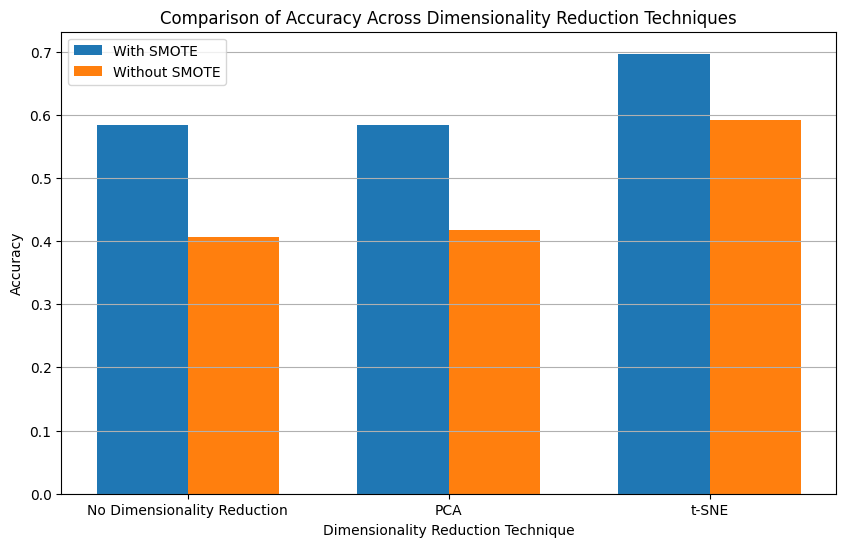

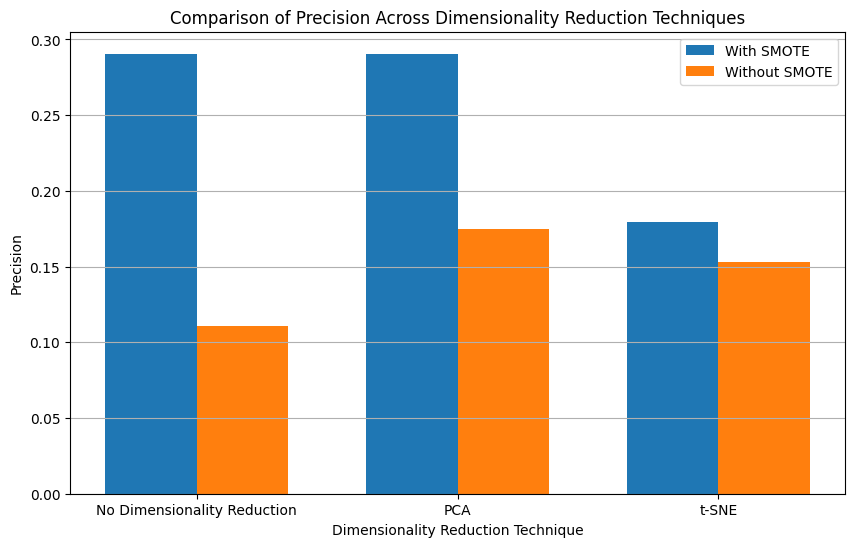

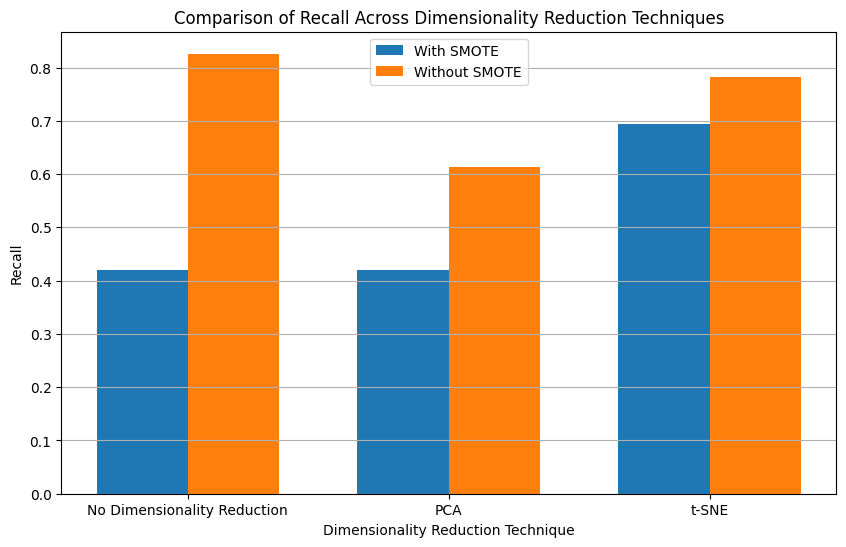

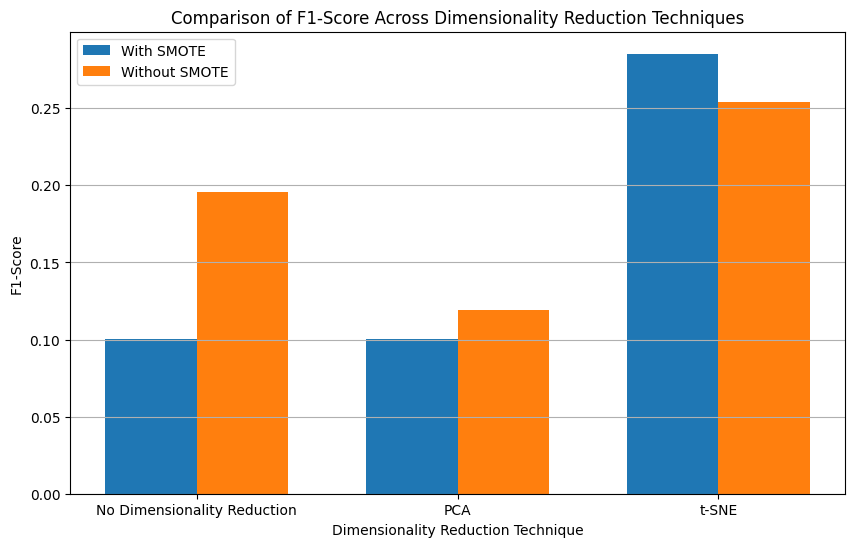

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# metrics from the output
metrics = {
    "No Dimensionality Reduction": {
        "SMOTE": metrics_no_reduction_smote,
        "No SMOTE": metrics_no_reduction_no_smote
    },
    "PCA": {
        "SMOTE": metrics_pca_smote,
        "No SMOTE": metrics_pca_no_smote
    },
    "t-SNE": {
        "SMOTE": metrics_tsne_smote,
        "No SMOTE": metrics_tsne_no_smote
    }
}

# plot the comparison with adjacent bars
methods = list(metrics.keys())
scores_smote = np.array([metrics[method]["SMOTE"] for method in methods])
scores_no_smote = np.array([metrics[method]["No SMOTE"] for method in methods])
metrics_labels = ["Accuracy", "Precision", "Recall", "F1-Score"]

x = np.arange(len(methods))
width = 0.35 

for i, metric_label in enumerate(metrics_labels):
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, scores_smote[:, i], width, label="With SMOTE")
    plt.bar(x + width/2, scores_no_smote[:, i], width, label="Without SMOTE")
    
    plt.title(f"Comparison of {metric_label} Across Dimensionality Reduction Techniques")
    plt.ylabel(metric_label)
    plt.xlabel("Dimensionality Reduction Technique")
    plt.xticks(x, methods)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

The introduction of SMOTE improves all metrics except Recall in all 3 dimensionality reductions. The addition of SMOTE dispropoirtionately increases the amount of fraud cases in the sample, causing the model to be more likely to predict fraud in a non-fraud case, decreasing the amount of frauds detected correctly as the model becomes more prone to false positives. The increase in fraud cases helps with the relatively low amount of fraud cases in the sample, helping the model correctly identify fraud cases.

The following block evaluates the test set after it has been trained on models using data altered by either PCA, t-SNE, or no dimension reduction.

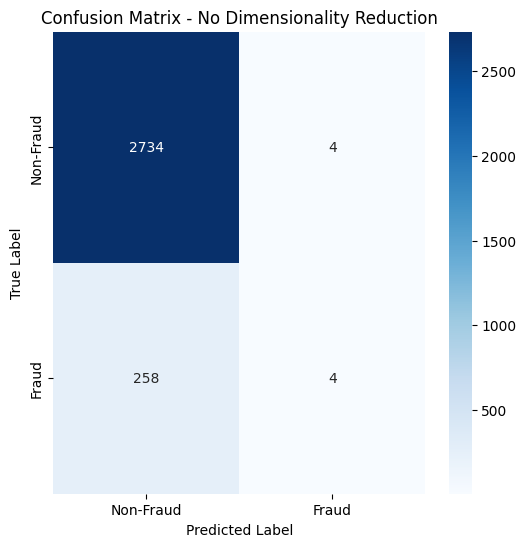

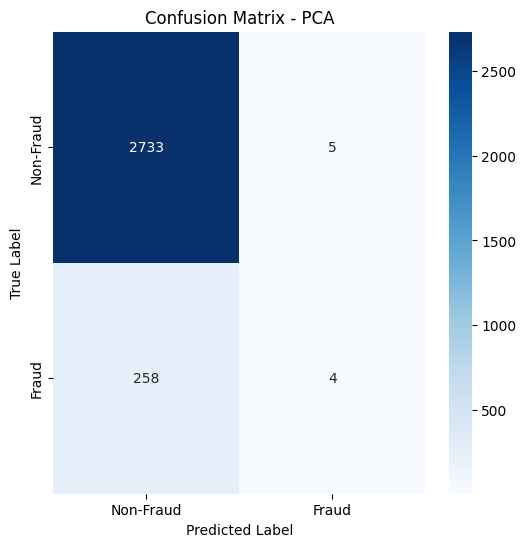

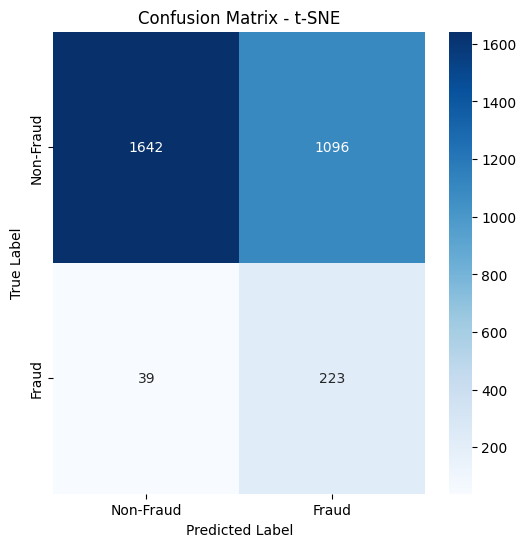

In [23]:
from sklearn.model_selection import train_test_split
import seaborn as sns

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# evaluate each testing function based on a different dimensional reduction using the optimal parameters
def evaluate_on_test_set(X_train, y_train, X_test, y_test, method=None):
    if method == "PCA":
        reducer = PCA(n_components=best_pca_threshold)
        X_train = reducer.fit_transform(X_train)
        X_test = reducer.transform(X_test)
        n_clusters = best_pca_clusters
    elif method == "t-SNE":
        reducer = TSNE(n_components=2, perplexity=best_tsne_perplexity, random_state=42, learning_rate=200)
        X_train = reducer.fit_transform(X_train)
        X_test = reducer.fit_transform(X_test) 
        n_clusters = best_tsne_clusters
    elif method is None:
        n_clusters = 2
    else:
        raise ValueError("Invalid dimensionality reduction method")

    # the dataset is upsampled with SMOTE due to the positive affects on metrics
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # the model is fit and predicted with the smote altered dataset and the optimal parameters
    gmm = GaussianMixture(n_components=n_clusters, n_init=50, covariance_type='tied', random_state=42)
    gmm.fit(X_train_smote)
    test_clusters = gmm.predict(X_test)

    # the same process of assigning each datapoint a cluster, and each cluster a label
    results_df = pd.DataFrame({'Cluster': test_clusters, 'Actual': y_test})
    cluster_label_mapping = pd.crosstab(results_df['Cluster'], results_df['Actual'])
    cluster_to_label = {
        cluster: 1.0 if (cluster_label_mapping.loc[cluster, 1.0] / cluster_label_mapping.loc[cluster].sum()) > original_fraud_ratio else 0.0
        for cluster in cluster_label_mapping.index
    }
    mapped_test_clusters = [cluster_to_label[cluster] for cluster in test_clusters]

    # create a confusion matrix based on the test results
    cm = confusion_matrix(y_test, mapped_test_clusters)

    return cm, X_test, test_clusters

# evaluate test sets and store results
methods = ["No Dimensionality Reduction", "PCA", "t-SNE"]
test_conf_matrices = {}
reduced_test_sets = {}
test_clusters_results = {}

# creates a confusion matrix for each method of dimensionality reduction
for method in methods:
    if method == "No Dimensionality Reduction":
        cm, _, _ = evaluate_on_test_set(X_train, y_train, X_test, y_test, method=None)
    else:
        cm, X_test_reduced, test_clusters = evaluate_on_test_set(X_train, y_train, X_test, y_test, method)
        reduced_test_sets[method] = X_test_reduced
        test_clusters_results[method] = test_clusters

    test_conf_matrices[method] = cm  # store confusion matrices

# generate heatmaps for the confusion matrices
for method, cm in test_conf_matrices.items():
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.title(f"Confusion Matrix - {method}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

PCA did not offer much change from no dimensionality reduction. Both of these training methods heavily favored non fraud so the likely reason for their high accuracy is because they never guess fraud, leading to a lot of false positives. Dimension reduction with t-SNE offered a substantial improvement, although still not good enough to use reliably. The model trained on data reduced by t-SNE correctly identified 223 fraud cases, a dramatic increase up from 4. However, this version of the model had a significantly higher false positive rate. Since the overall rate of fraud is so low, this could be suboptimal as it could misflag many more transactions that necessary.

The following block graphs the clusters in unique colors, with a seperate hollow red triange symbol that highlights the fraud causes.

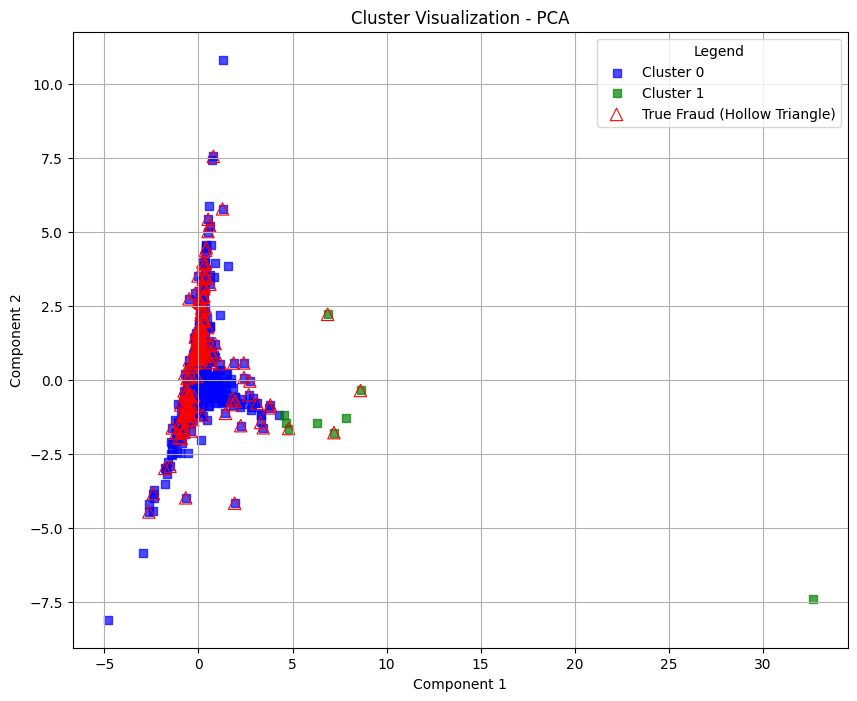

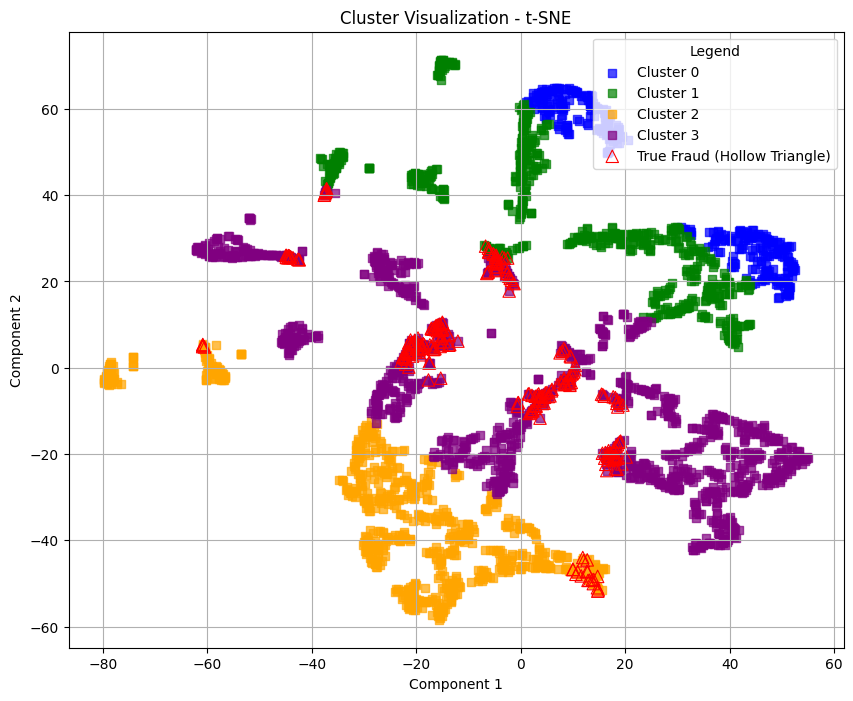

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to plot clusters dynamically for any number of clusters
def plot_clusters(X_test_transformed, y_test, clusters, method_name):
    plt.figure(figsize=(10, 8))

    # define a distinct color palette for clusters (excluding red)
    cluster_colors = ['blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'brown', 'pink', 'gray']
    unique_clusters = np.unique(clusters)

    if len(unique_clusters) > len(cluster_colors):
        raise ValueError("Too many clusters for the predefined color palette. Add more colors if needed.")

    # plot each cluster with a distinct color
    for i, cluster in enumerate(unique_clusters):
        cluster_indices = (clusters == cluster)
        plt.scatter(
            X_test_transformed[cluster_indices, 0],
            X_test_transformed[cluster_indices, 1],
            c=cluster_colors[i],
            marker='s',
            label=f"Cluster {cluster}",
            alpha=0.7
        )

    # overlay true fraud cases (y_test == 1) as hollow red triangles
    true_fraud_indices = (y_test == 1).values
    plt.scatter(
        X_test_transformed[true_fraud_indices, 0],
        X_test_transformed[true_fraud_indices, 1],
        edgecolor='red',
        facecolor="none",
        marker='^',
        linewidths=0.8,
        s=80,
        label="True Fraud (Hollow Triangle)"
    )

    plt.title(f"Cluster Visualization - {method_name}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Legend", loc="upper right")
    plt.grid(True)
    plt.show()

# graph clusters for PCA and t-SNE
for method in ["PCA", "t-SNE"]:
    if method in reduced_test_sets:
        plot_clusters(
            reduced_test_sets[method],
            y_test,
            test_clusters_results[method],
            method_name=method
        )

The clusters are visualized on each of the graphs, one with a PCA reduction and the other with t-SNE. In each graph, the fraudulunt data points (the red hollow triangles) don't seem to relate with any of the other clusters. This fact, combined with the lack of reliable testing results after many forms of preprocessing leads me to believe that the GMM model is not well suited for this classification problem.